In [4]:
import sys, os, glob, datetime, cftime,pickle,re
import xarray as xr
import numpy as np
import pandas as pd
import regionmask

import matplotlib
import matplotlib.pyplot as plt
import cartopy

sys.path.append('../')
from linear_regression import get_slope_and_pval

In [33]:
def load_tas_from_scen(scen):
    files = glob.glob(f'/work/bb1445/m300755/archive/{scen}_1952-2015/atm/hist/*.h1.*')
    files += glob.glob(f'/work/bb1445/m300755/archive/{scen}_2015-2023/atm/hist/*.h1.*')
    files = [f for f in files if int(f[-5:-3]) in [6,7,8] and int(f[-10:-6]) in list(range(1979,2024))]
    files = sorted(files)
    with xr.open_mfdataset(files) as nc:
        nc = nc.assign_coords(year=nc.time.dt.year)
        nc = nc.swap_dims({'time': 'year'})
        nc = nc.assign_coords(lon=(nc.lon + 180) % 360 - 180)
        return nc['TREFHT'].sel(lat=slice(30,60))

In [32]:
xr.open_dataset('/work/bb1445/m300755/archive/CO2pi_LUh_Aerpi_1952-2015/atm/hist/CO2pi_LUh_Aerpi_1952-2015.cam.h1.1979-06.nc')

<xarray.Dataset> Size: 3MB
Dimensions:       (lat: 192, lon: 288, lev: 32, ilev: 33, time: 1, nbnd: 2)
Coordinates:
  * lat           (lat) float64 2kB -90.0 -89.06 -88.12 ... 88.12 89.06 90.0
  * lon           (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * lev           (lev) float64 256B 3.643 7.595 14.36 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 264B 2.255 5.032 10.16 ... 967.5 985.1 1e+03
  * time          (time) object 8B 1979-07-01 00:00:00
Dimensions without coordinates: nbnd
Data variables: (12/37)
    gw            (lat) float64 2kB ...
    hyam          (lev) float64 256B ...
    hybm          (lev) float64 256B ...
    P0            float64 8B ...
    hyai          (ilev) float64 264B ...
    hybi          (ilev) float64 264B ...
    ...            ...
    TREFHT        (time, lat, lon) float32 221kB ...
    TREFHTMN      (time, lat, lon) float32 221kB ...
    TREFHTMX      (time, lat, lon) float32 221kB ...
    TREFMNAV      (time, lat, lon) float32 221kB ...
    TREFMXAV      (time, lat, lon) float32 221kB ...
    Z500          (time, lat, lon) float32 221kB ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              CO2pi_LUh_Aerpi_1952-2015
    logname:           m300755
    host:              
    initial_file:      /work/mj0143/m300755/inputdata/atm/cam/inic/fv/cami-ma...
    topography_file:   /work/mj0143/m300755/inputdata/atm/cam/topo/fv_0.9x1.2...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  month_1

In [34]:
tas_CO2pi_LUh_Aerpi = load_tas_from_scen('CO2pi_LUh_Aerpi')

In [35]:
tas_CO2h_LUh_Aerpi = load_tas_from_scen('CO2h_LUh_Aerh')

In [36]:
component_dict = dict(
    circ = dict(tas = tas_CO2pi_LUh_Aerpi),
    thermo = dict(tas = tas_CO2h_LUh_Aerpi - tas_CO2pi_LUh_Aerpi),
)

In [37]:
for name,d in component_dict.items():
    slope, p_value = get_slope_and_pval(d['tas'].load())
    mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(slope.lon, slope.lat)
    mask.values[np.isfinite(mask)] = 1
    slope = slope * mask
    p_value = p_value * mask
    component_dict[name] = (slope * 10, p_value)

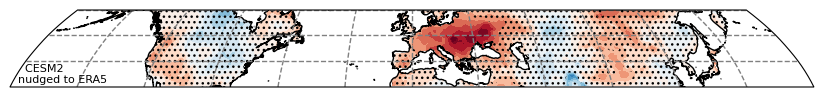

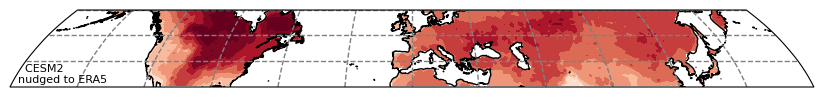

In [40]:
maxabs = 0.6
levels = np.linspace(-maxabs,maxabs,17)
for name,d in component_dict.items():
    fig,ax = plt.subplots(nrows=1, figsize=(12, 1), subplot_kw={'projection': cartopy.crs.Robinson()})
    ax.coastlines()
    ax.set_extent([-180, 180, 30, 60], crs=cartopy.crs.PlateCarree())
    trend = component_dict[name][0]
    trend = trend.roll(lon=int(0.5*trend.shape[1]), roll_coords=True)
    im = ax.contourf(trend.lon, trend.lat, trend, transform=cartopy.crs.PlateCarree(), cmap='RdBu_r', levels=levels, extend='both')
    ax.annotate('  CESM2\nnudged to ERA5', xy=(0.01,0.05), xycoords='axes fraction', fontsize=8)
    ax.set_facecolor('w')

    gl = ax.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=False,
                linewidth=1, color='gray', alpha=1, linestyle='--')
    gl.xlocator = matplotlib.ticker.FixedLocator(np.arange(-180,200,30,'int'))
    gl.ylocator = matplotlib.ticker.FixedLocator(np.arange(40,61,10,'int'))

    plt.savefig(f"CESM2_nudged_to_ERA5_trends_1979-2023_{name}.pdf", bbox_inches='tight')
    plt.savefig(f"CESM2_nudged_to_ERA5_trends_1979-2023_{name}.png", bbox_inches='tight', dpi=300)

    xxx = component_dict[name][1]
    cs1 = ax.contourf(xxx.lon, xxx.lat, xxx, transform=cartopy.crs.PlateCarree(), colors='none', hatches=['','...'], levels=[0,0.05,1])
    plt.savefig(f"CESM2_nudged_to_ERA5_trends_1979-2023_{name}_sig.pdf", bbox_inches='tight')
    plt.savefig(f"CESM2_nudged_to_ERA5_trends_1979-2023_{name}_sig.png", bbox_inches='tight', dpi=300)

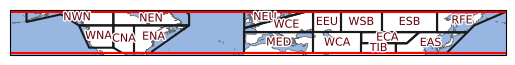

In [8]:
from _srex_regions import get_mask,plot_regions
mask,regions = get_mask(trend, ignored_regions=['GIC','NAO','NPO','NCA'])
plot_regions(regions[mask.region.values])

In [9]:
weights = np.cos(np.deg2rad(trend.lat))
land_mask = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask(trend.lon, trend.lat)
land_mask.values[np.isfinite(land_mask)] = 1

In [10]:
for name,d in component_dict.items():
    trend = component_dict[name]['trend']
    component_dict[name]['trend_reg'] = regional_trends = xr.DataArray(dims=["region"], coords = dict(region=mask.abbrevs))
    for reg in regional_trends.region:
        y_ = trend * mask.loc[mask.abbrevs == reg] * land_mask
        component_dict[name]['trend_reg'].loc[reg] = y_.weighted(weights).mean() * 10

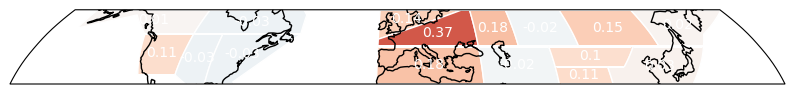

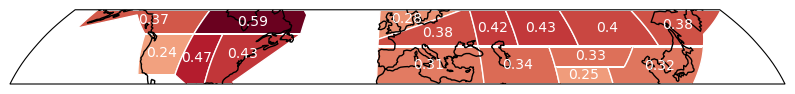

In [11]:
cmap = matplotlib.colormaps.get_cmap('RdBu_r')
norm = matplotlib.colors.Normalize(vmin=-0.6, vmax=0.6)

for name,d in component_dict.items():
    regional_trends = component_dict[name]['trend_reg']
    fig,ax = plt.subplots(nrows=1, figsize=(10, 1), subplot_kw={'projection': cartopy.crs.Robinson()})
    ax.set_extent([-180,180,30,60], crs=cartopy.crs.PlateCarree())
    ax.coastlines(zorder=10, resolution='110m')
    for reg_name,polygon in zip(regions.abbrevs, regions.polygons):
        x = regional_trends.loc[reg_name].values.mean()
        ax.add_geometries(polygon, cartopy.crs.PlateCarree(),
                        facecolor=cmap(norm(x)), edgecolor='w')
        lon,lat = np.array(polygon.centroid.xy).flatten()
        if lat > 60:
            lat = 57
        ax.annotate(round(x,2), (lon,lat), transform=cartopy.crs.PlateCarree(), ha='center', va='center', color='w', zorder=11)
    #ax.spines['geo'].set_edgecolor('white')
    plt.savefig(f"../plots/CESM2_nudged_to_ERA5_trends_1979-2023_srex_{name}.pdf", bbox_inches='tight')
    plt.savefig(f"../plots/CESM2_nudged_to_ERA5_trends_1979-2023_srex_{name}.png", bbox_inches='tight', dpi=300)